# File layout

## Measurements are done with FX23-W3-02-V3.3-Qubit 1 only
### EC=0.991093GHz but if I add JJ's pad EC=0.9570GHz

For this analysis file, it is required to download the data of the following days from sharepoint:
* 20230306
* 20230307
* 20230308
* 20230328
* 20230329
* 20230330
* 20230401
* 20230402
* 20230513
* 20230514
* 20230515

- This JN prepared by Martijn F.S. Zwanenburg and editted by Figen Yilmaz

# Initilization

In [1]:
import os
import numpy as np
import h5py
import json
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import scqubits as scq
from scqubits import HilbertSpace, ParameterSweep

from config import base_dir
from utils import get_data_folders
from utils import interp_fr
from utils import fig_prepare
from utils import asymmetric_lorentzian, double_asymmetric_lorentzian

# Create directory for figures if it doesn't exist
output_dir = "outputs/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function used to analyse parameter sweeps
def get_sweep_transition(sweep, initial_state, final_state):
    transitions = sweep[:].transitions(initial=initial_state)
    final_states = [transitions[0][i][-1] for i in range(len(transitions[0]))]
    idx = final_states.index(final_state)
    return transitions[1][idx]

In [4]:
# Ensure font sizes are large enough to read
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

# Load data

In [5]:
## Define all relevant data sets

# Data set 1
data_folders_1 = np.concatenate((
    get_data_folders(base_dir+"20230328/", start=132930, stop=235999),
    get_data_folders(base_dir+"20230329/", start=0, stop=22124)
))

# Data set 2
data_folders_2 = get_data_folders(base_dir+"20230329/", start=104454, stop=152455)

# Data set 3
data_folders_3 = get_data_folders(base_dir+"20230330/", start=133950, stop=183810)

# Data set 4
data_folders_4 = np.concatenate((
    get_data_folders(base_dir+"20230401/", start=175255, stop=235999),
    get_data_folders(base_dir+"20230402/", start=0, stop=60251)
))

# Data set 5
data_folders_5 = np.concatenate((
    get_data_folders(base_dir+"20230307/", start=204543, stop=235999),
    get_data_folders(base_dir+"20230308/", start=0, stop=53048)
))

# Data set 6
data_folders_6 = np.concatenate((
    get_data_folders(base_dir+"20230513/", start=222525, stop=235959),
    get_data_folders(base_dir+"20230514/", start=0, stop=30428)
))

# Data set 7
data_folders_7 = get_data_folders(base_dir+"20230514/", start=92503, stop=114251)

# Data set 8
data_folders_8 = get_data_folders(base_dir+"20230515/", start=91453, stop=150943)

# All data sets
all_data_folders = [data_folders_1, data_folders_2, data_folders_3, data_folders_4, data_folders_5, data_folders_6, data_folders_7, data_folders_8]

# Analyze individual measurements

Here, we quickly take a look at all the 8 individual measurements, such that we can get an idea of the range and if we want to add them to the final analysis.

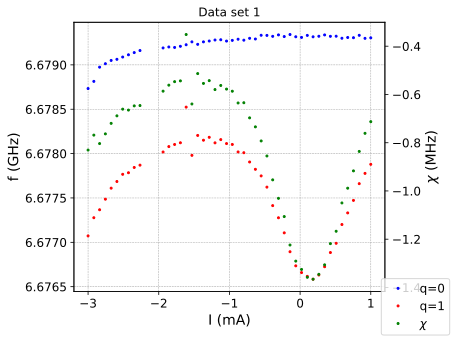

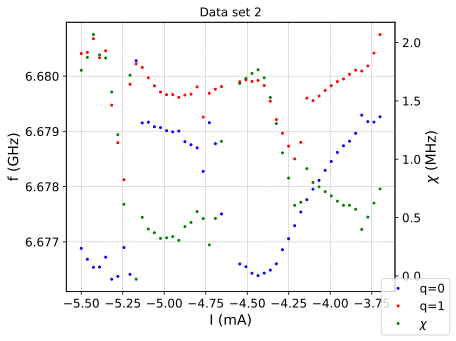

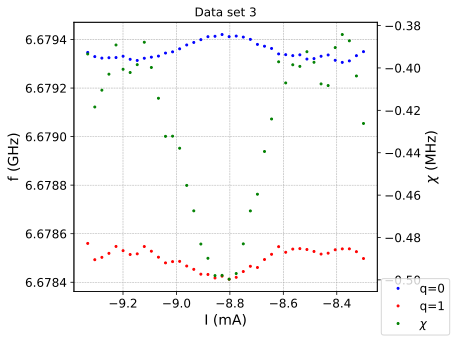

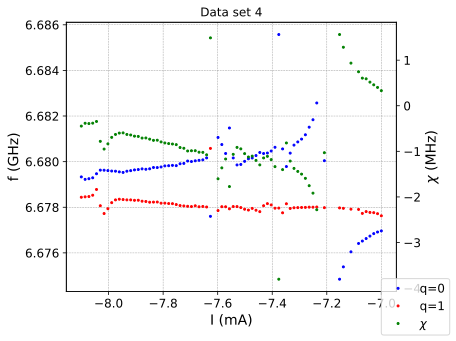

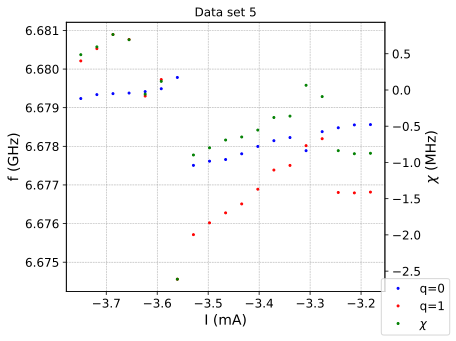

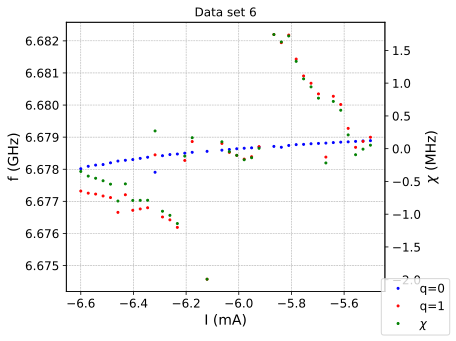

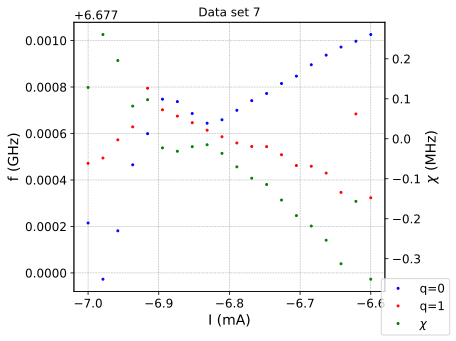

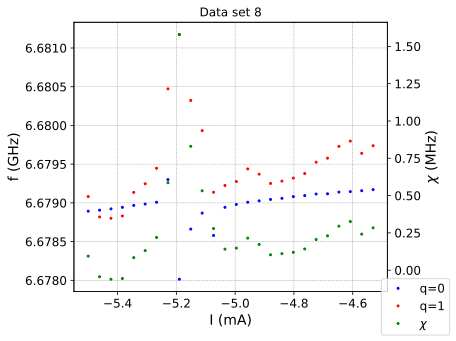

In [6]:
for j,data_folders in enumerate(all_data_folders):
    data_folders_disp_shift = []
    for i,data_folder in enumerate(data_folders):
        r = "Dispersive shift q1"
        if data_folder[-len(r):] == r:
            data_folders_disp_shift.append(data_folder)

    results_x = np.array([])
    results_y0 = np.array([])
    results_y1 = np.array([])
    results_y2 = np.array([])

    for i,data_folder in enumerate(data_folders_disp_shift):
        # Load snapshot to get flux
        with open(data_folder+"/snapshot.json", "r") as f:
            snapshot = json.load(f)
            flux = snapshot["instruments"]["flux_mod"]["parameters"]["FL1"]["value"]
            fq = snapshot["instruments"][f"q1"]["submodules"]["clock_freqs"]["parameters"]["f01"]["value"]

        with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
            x0 = np.array(list(f["x0"]))
            y0 = np.array(list(f["y0"]))
            y1 = np.array(list(f["y1"]))

        data_frequency = x0[:len(x0)//2]
        data_0_trace = y0[:len(x0)//2]
        data_1_trace = y0[len(x0)//2:]

        frs = []
        popts = []
        fit_success = True    
        for S21 in [data_0_trace, data_1_trace]:
            _mag = np.abs(S21)
            p0 = [1e-4, -1e6, data_frequency[np.argmin(_mag)], 2*np.pi*np.mean(data_frequency)/4e3, 2*np.pi*np.mean(data_frequency)/1e4, 0]
            # p0 = [1e-4, -1e6, data_frequency[np.argmin(_mag)], 2*np.pi*np.mean(data_frequency)/4e3, -9e6, 0]
            try:
                popt,pcov = curve_fit(asymmetric_lorentzian, data_frequency, _mag, p0=p0)
                frs.append(popt[2])
                popts.append(popt)
            except:
                fit_success = False

        # Only keep the results if the fits were succesful
        if fit_success:
            results_y0 = np.append(results_y0, frs[0])
            results_y1 = np.append(results_y1, frs[1])
            results_y2 = np.append(results_y2, fq)
            results_x = np.append(results_x, flux)

    # Plot
    idx = np.argsort(results_x)
    fig,ax = fig_prepare("I (mA)","f (GHz)")
    ax.plot(results_x[idx]*1e3, results_y0[idx]*1e-9, label="q=0", linestyle="", marker=".", markersize=4, color="b")
    ax.plot(results_x[idx]*1e3, results_y1[idx]*1e-9, label="q=1", linestyle="", marker=".", markersize=4, color="r")

    ax2 = ax.twinx()
    ax2.set_ylabel(r"$\chi$ (MHz)")
    ax2.plot(results_x[idx]*1e3, (results_y1[idx]-results_y0[idx])*1e-6/2, linestyle="", marker=".", markersize=4, color="g", label=r"$\chi$")
    ax.set_title(f"Data set {j+1}")
    fig.legend(loc=4)
    fig.tight_layout()
    
    

When evaluating the figures outputted in the cell below, we conclude the following:
* Data set 2 will be discarded. Here, we see an additional feature at -4.4 mA, which we concluded was due to the choice of IF. At this choice of IF, the LO leakage was driving some transition. The measurements in this range were redone, and are in data set 8. See the measurement one note notebook for more details.

In [8]:
# All data folders used for subsequent analysis
all_data_folders = np.concatenate((
    data_folders_1, 
    data_folders_3, 
    data_folders_4, 
    data_folders_5, 
    data_folders_6, 
    data_folders_7, 
    data_folders_8
))

# Process data

Here, we focus on obtainin Chi and fq from all the measurements. The analysis done in this section is very basic, and has two important shortcomings which we will resolve later:
1. We should fit double Lorentzians rather than single Lorentzians.
2. Some data is "unfittable" and some data is fitted, but has a super bad fit. In both cases, the results should either be fixed or omitted from the final figures. Unfittable resonators appear very close to the avoided crossings, where resonators can disappear from the spectrum.

## Chi

In [9]:
# Filter for disp shift measurements
data_folders_disp_shift = []
for i,data_folder in enumerate(all_data_folders):
    r = "Dispersive shift q1"
    if data_folder[-len(r):] == r:
        data_folders_disp_shift.append(data_folder)

### Single Lorentzian

In [10]:
# Indices of folders to skip
# Note that measurements for which the fit fails are automatically skipped in the figures
skip_indices = []

In [11]:
results_x = np.array([])
results_y0 = np.array([])
results_y1 = np.array([])
results_y2 = np.array([])

for i,data_folder in enumerate(data_folders_disp_shift):
    if i in skip_indices:
        continue
    # Load snapshot to get flux
    with open(data_folder+"/snapshot.json", "r") as f:
        snapshot = json.load(f)
        flux = snapshot["instruments"]["flux_mod"]["parameters"]["FL1"]["value"]
        fq = snapshot["instruments"][f"q1"]["submodules"]["clock_freqs"]["parameters"]["f01"]["value"]

    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        x0 = np.array(list(f["x0"]))
        y0 = np.array(list(f["y0"]))
        y1 = np.array(list(f["y1"]))

    data_frequency = x0[:len(x0)//2]
    data_0_trace = y0[:len(x0)//2]
    data_1_trace = y0[len(x0)//2:]

    frs = []
    popts = []
    fit_success = True    
    for S21 in [data_0_trace, data_1_trace]:
        _mag = np.abs(S21)
        p0 = [1e-4, -1e6, data_frequency[np.argmin(_mag)], 2*np.pi*np.mean(data_frequency)/4e3, 2*np.pi*np.mean(data_frequency)/1e4, 0]
        try:
            popt,pcov = curve_fit(asymmetric_lorentzian, data_frequency, _mag, p0=p0)
            frs.append(popt[2])
            popts.append(popt)
        except:
            fit_success = False

    # Only keep the results if the fits were succesful
    if fit_success:
        results_y0 = np.append(results_y0, frs[0])
        results_y1 = np.append(results_y1, frs[1])
        results_y2 = np.append(results_y2, fq)
        results_x = np.append(results_x, flux)

    if fit_success:
        chi = 1e-6*(frs[1]-frs[0])/2 # In MHz
        fig,ax = fig_prepare("f (GHz)", "Signal (a.u.)")
        ax.plot(data_frequency*1e-9, asymmetric_lorentzian(data_frequency, *popts[0]), color="b")
        ax.plot(data_frequency*1e-9, data_0_trace, linestyle="", marker=".", markersize=2, color="b")
        ax.plot(data_frequency*1e-9, asymmetric_lorentzian(data_frequency, *popts[1]), color="r")
        ax.plot(data_frequency*1e-9, data_1_trace, linestyle="", marker=".", markersize=2, color="r")
        ax.set_title(f"{np.round(flux*1e3,3)} mA, chi={np.round(chi,3)}")
        fig.tight_layout()
        fig.savefig(f"{output_dir}{i}.png", dpi=200)
        plt.close("all")
    else:
        fig,ax = fig_prepare("f (GHz)", "Signal (a.u.)")
        ax.plot(data_frequency*1e-9, data_0_trace, linestyle="", marker=".", markersize=2, color="b")
        ax.plot(data_frequency*1e-9, data_1_trace, linestyle="", marker=".", markersize=2, color="r")
        ax.set_title(f"{np.round(flux*1e3,3)} mA, fit failed")
        fig.tight_layout()
        fig.savefig(f"{output_dir}{i}.png", dpi=200)
        plt.close("all")
        print(f"Failed fit at i={i}, I={flux}, data folder={data_folders_disp_shift[i].split('/')[-1]}")

Failed fit at i=149, I=-0.0072227848101265825, data folder=20230402-033353-091-2849a6-Dispersive shift q1
Failed fit at i=151, I=-0.00719493670886076, data folder=20230402-035229-428-07cd9b-Dispersive shift q1
Failed fit at i=152, I=-0.007181012658227848, data folder=20230402-040150-323-16edda-Dispersive shift q1
Failed fit at i=153, I=-0.0071670886075949364, data folder=20230402-041111-321-aa4003-Dispersive shift q1
Failed fit at i=156, I=-0.007125316455696203, data folder=20230402-043905-034-54c9df-Dispersive shift q1
Failed fit at i=158, I=-0.00709746835443038, data folder=20230402-045746-087-d704e1-Dispersive shift q1
Failed fit at i=201, I=-0.0061487179487179485, data folder=20230514-002119-073-7c19e1-Dispersive shift q1
Failed fit at i=203, I=-0.006092307692307692, data folder=20230514-003535-315-0e633d-Dispersive shift q1
Failed fit at i=210, I=-0.0058948717948717946, data folder=20230514-012500-616-7bb49a-Dispersive shift q1


In [12]:
# Get indices to sort data w.r.t. the currents
idx = np.argsort(results_x)

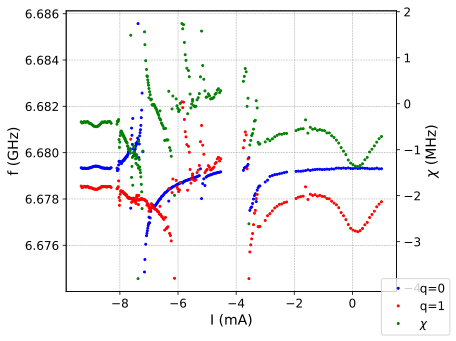

In [13]:
# Plot fitted resonators and chi vs frequency
fig,ax = fig_prepare("I (mA)","f (GHz)")
ax.plot(results_x[idx]*1e3, results_y0[idx]*1e-9, label="q=0", linestyle="", marker=".", markersize=4, color="b")
ax.plot(results_x[idx]*1e3, results_y1[idx]*1e-9, label="q=1", linestyle="", marker=".", markersize=4, color="r")

ax2 = ax.twinx()
ax2.set_ylabel(r"$\chi$ (MHz)")
ax2.plot(results_x[idx]*1e3, (results_y1[idx]-results_y0[idx])*1e-6/2, linestyle="", marker=".", markersize=4, color="g", label=r"$\chi$")
fig.legend(loc=4)
fig.tight_layout()
fig.savefig("chi.png", dpi=200)

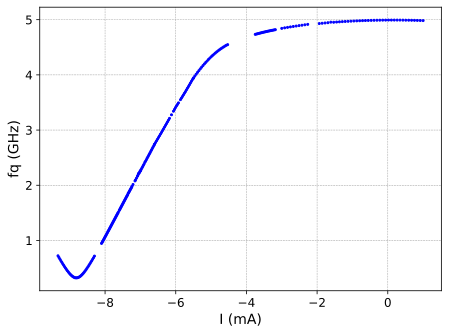

In [14]:
fig,ax = fig_prepare("I (mA)","fq (GHz)")
ax.plot(results_x[idx]*1e3, results_y2[idx]*1e-9, linestyle="", marker=".", markersize=4, color="b")
fig.tight_layout()
fig.savefig("fq.png", dpi=200)

In [15]:
# Get and process results from resonator-flux scan for comparison
data_folders = get_data_folders(base_dir+"20230306/", start=105854, stop=105854)
data_folder = data_folders[0]

dir_name = data_folders[0]
with h5py.File(dir_name+"/analysis_ResonatorFluxScanAnalysis/dataset_processed.hdf5", "r") as f:
    data_bias_current = np.array(list(f["bias_current"]))
    data_frequency = np.array(list(f["frequency"]))
    data_mag = np.array(list(f["magnitude"]))

N = np.size(data_bias_current)
frs = []
for i in range(N):

    _mag = data_mag[:,i]
    p0 = [0, 1e6, np.mean(data_frequency), 2*np.pi*np.mean(data_frequency)/5e3, 2*np.pi*np.mean(data_frequency)/1e12, 0]
    
    try:
        popt,pcov = curve_fit(asymmetric_lorentzian, data_frequency, _mag, p0=p0)
        frs.append(popt[2])
    except Exception as e:
        print(e)
        frs.append(data_frequency[np.argmin(_mag)])

Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


In [ ]:
xx = np.linspace(np.min(results_x), np.max(results_x), 1000)
fig,ax = fig_prepare("I (mA)","~fr (GHz)")
ax.plot(results_x[idx]*1e3, results_y0[idx]*1e-9, label="q=0", linestyle="", marker=".", markersize=4, color="b")
ax.plot(results_x[idx]*1e3, results_y1[idx]*1e-9, label="q=1", linestyle="", marker=".", markersize=4, color="r")
ax.plot(data_bias_current*1e3, np.array(frs)*1e-9, linestyle="", marker=".", markersize=7, color="#333")
ax.set_xlim(left=np.min(results_x)*1e3,right=np.max(results_x*1e3))

ax2 = ax.twinx()
ax2.set_ylabel(r"$\chi$ (MHz)")
ax2.plot(results_x[idx]*1e3, (results_y1[idx]-results_y0[idx])*1e-6/2, linestyle="", marker=".", markersize=4, color="g", label=r"$\chi$")
fig.legend(loc=4)
fig.tight_layout()
fig.savefig("chi.png", dpi=200)

Error in callback <function flush_figures at 0x00000265C049D760> (for post_execute), with arguments args (),kwargs {}:


Based on reviewing the fits in the output directory, we can update the list of skipped measurements

In [38]:
skip_indices = [94, 95, 96, 97, 98, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 256, 257, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 278, 279, 280, 281, 282, 283, 284, 293, 294, 297, 298, 303, 306, 307, 308]

### Fit chi with double Lorentzians

In [17]:
skip_indices = []

In [39]:
# Indices of folders to skip
# Note that measurements for which the fit fails are automatically skipped in the figures
skip_indices = [95, 124, 130, 131, 132, 133, 141, 143, 151, 153, 154, 155, 156, 192, 193, 194, 210, 216, 219, 220, 221, 222, 225, 226, 227, 229, 231, 233, 234, 240, 241, 242, 243, 256, 266, 267, 268, 269, 270, 271, 303]

In [40]:
results_x_fr0 = np.array([])
results_y_fr0 = np.array([])

results_x_fr1 = np.array([])
results_y_fr1 = np.array([])

results_x_chi = np.array([])
results_y_chi = np.array([])

results_x_fq = np.array([])
results_y_fq = np.array([])

for i,data_folder in enumerate(data_folders_disp_shift):

    # Load snapshot to get flux and fq
    with open(data_folder+"/snapshot.json", "r") as f:
        snapshot = json.load(f)
        flux = snapshot["instruments"]["flux_mod"]["parameters"]["FL1"]["value"]
        fq = snapshot["instruments"]["q1"]["submodules"]["clock_freqs"]["parameters"]["f01"]["value"]

        # Store fq results
        results_x_fq = np.append(results_x_fq, flux)
        results_y_fq = np.append(results_y_fq, fq)

    # Load hdf5 file to get data
    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        x0 = np.array(list(f["x0"]))
        y0 = np.array(list(f["y0"]))
        y1 = np.array(list(f["y1"]))

    # Parse data into 0 and 1 traces
    data_frequency = x0[:len(x0)//2]
    data_0_trace = y0[:len(x0)//2]
    data_1_trace = y0[len(x0)//2:]

    # Prepare arrays to store fitted data
    frs_sl = []
    popts_sl = [None, None]
    popts_dl = [None, None]
    fit_success_sl_trace0 = True
    fit_success_sl_trace1 = True
    fit_success_dl_trace0 = True
    fit_success_dl_trace1 = True

    # Fit resonator trace 0
    try:
        p0 = [1e-4, -1e6, data_frequency[np.argmin(np.abs(data_0_trace))], 2*np.pi*np.mean(data_frequency)/4e3, 2*np.pi*np.mean(data_frequency)/1e4, 0]
        popt,pcov = curve_fit(asymmetric_lorentzian, data_frequency, np.abs(data_0_trace), p0=p0)

        # If we get here, the fir succeeded and we can save the data
        popts_sl[0] = popt
        results_x_fr0 = np.append(results_x_fr0, flux)
        results_y_fr0 = np.append(results_y_fr0, popt[2])
    except RuntimeError:
        fit_success_sl_trace0 = False

    # Fit resonator trace 1
    try:
        p0 = [1e-4, -1e6, data_frequency[np.argmin(np.abs(data_1_trace))], 2*np.pi*np.mean(data_frequency)/4e3, 2*np.pi*np.mean(data_frequency)/1e4, 0]
        popt,pcov = curve_fit(asymmetric_lorentzian, data_frequency, np.abs(data_1_trace), p0=p0)

        # If we get here, the fir succeeded and we can save the data
        popts_sl[1] = popt
        results_x_fr1 = np.append(results_x_fr1, flux)
        results_y_fr1 = np.append(results_y_fr1, popt[2])
    except RuntimeError:
        fit_success_sl_trace1 = False

    # If the fits to trace0 and trace1 succeeded, we can calculate chi and
    # we can try to improve the fit with double Lorentzians
    if fit_success_sl_trace0 and fit_success_sl_trace1:
        # Try to fit trace0 with double Lorentzian
        try:
            bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1])
            p0 = [popts_sl[0][0], popts_sl[0][1], popts_sl[0][2], popts_sl[1][2], popts_sl[0][3], popts_sl[1][3], popts_sl[0][4], popts_sl[1][4], popts_sl[0][5], 1]
            popt,pcov = curve_fit(double_asymmetric_lorentzian, data_frequency, np.abs(data_0_trace), p0=p0, bounds=bounds)

            # If we get here, the DL fit succeeded and we can update the stored fit parameters
            popts_dl[0] = popt
            results_y_fr0[-1] = popt[2]
        except RuntimeError:
            fit_success_dl_trace0 = False

        # Try to fit trace1 with double Lorentzian
        try:
            bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1])
            p0 = [popts_sl[0][0], popts_sl[0][1], popts_sl[0][2], popts_sl[1][2], popts_sl[0][3], popts_sl[1][3], popts_sl[0][4], popts_sl[1][4], popts_sl[0][5], 0]
            popt,pcov = curve_fit(double_asymmetric_lorentzian, data_frequency, np.abs(data_1_trace), p0=p0, bounds=bounds)

            # If we get here, the DL fit succeeded and we can update the stored fit parameters
            popts_dl[1] = popt
            results_y_fr1[-1] = popt[3]
        except RuntimeError:
            fit_success_dl_trace1 = False

        
        # Now, end by calculating Chi
        # Note that results_y_fr1[-1] and results_y_fr0[-1] might come from SL
        # or DL fits, but we don't care too much from where
        # Note that we also assume that if the DL fit works, that it is always better than the SL fit
        results_x_chi = np.append(results_x_chi, flux)
        results_y_chi = np.append(results_y_chi, (results_y_fr1[-1]-results_y_fr0[-1])/2)

    # # Make a figure
    # fig,ax = fig_prepare("f (GHz)", "Signal (a.u.)")

    # # Plot fit trace 0 if it exists
    # if popts_dl[0] is not None:
    #     ax.plot(data_frequency*1e-9, double_asymmetric_lorentzian(data_frequency, *popts_dl[0]), color="b", label="0 DL")
    # elif fit_success_sl_trace0:
    #     ax.plot(data_frequency*1e-9, asymmetric_lorentzian(data_frequency, *popts_sl[0]), color="b", label="0 SL")

    # # Plot fit trace 1 if it exists
    # if popts_dl[1] is not None:
    #     ax.plot(data_frequency*1e-9, double_asymmetric_lorentzian(data_frequency, *popts_dl[1]), color="r", label="1 DL")
    # elif fit_success_sl_trace1:
    #     ax.plot(data_frequency*1e-9, asymmetric_lorentzian(data_frequency, *popts_sl[1]), color="r", label="1 SL")


    # # Plot trace0 and trace1
    # ax.plot(data_frequency*1e-9, data_0_trace, linestyle="", marker=".", markersize=2, color="b")
    # ax.plot(data_frequency*1e-9, data_1_trace, linestyle="", marker=".", markersize=2, color="r")
    # ax.set_title(f"{np.round(flux*1e3,3)} mA")
    # fig.legend()
    # fig.tight_layout()
    # fig.savefig(f"outputs/{i}.png", dpi=200)
    # plt.close("all")


In [41]:
# Sort
idx_fq = np.argsort(results_x_fq)
idx_fr0 = np.argsort(results_x_fr0)
idx_fr1 = np.argsort(results_x_fr1)
idx_chi = np.argsort(results_x_chi)

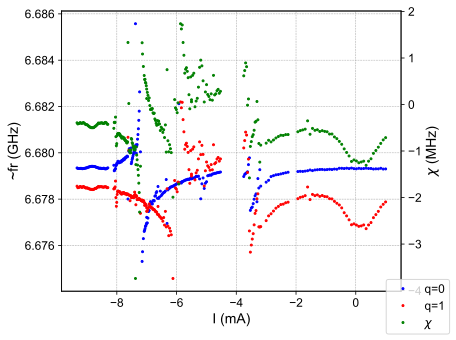

In [42]:
fig,ax = fig_prepare("I (mA)","~fr (GHz)")
ax.plot(results_x_fr0[idx_fr0]*1e3, results_y_fr0[idx_fr0]*1e-9, label="q=0", linestyle="", marker=".", markersize=4, color="b")
ax.plot(results_x_fr1[idx_fr1]*1e3, results_y_fr1[idx_fr1]*1e-9, label="q=1", linestyle="", marker=".", markersize=4, color="r")

ax2 = ax.twinx()
ax2.set_ylabel(r"$\chi$ (MHz)")
ax2.plot(results_x_chi[idx_chi]*1e3, results_y_chi[idx_chi]*1e-6, linestyle="", marker=".", markersize=4, color="g", label=r"$\chi$")
fig.legend(loc=4)
fig.tight_layout()
fig.savefig("chi.png", dpi=200)

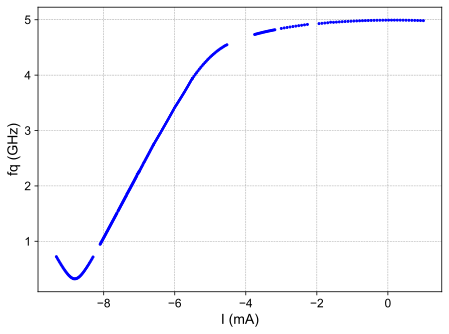

In [44]:
fig,ax = fig_prepare("I (mA)","fq (GHz)")
ax.plot(results_x_fq[idx_fq]*1e3, results_y_fq[idx_fq]*1e-9, label="q=0", linestyle="", marker=".", markersize=4, color="b")
fig.tight_layout()
fig.savefig("Qubit_f.png", dpi=200)

In [48]:
## here, we save all the measurement data 
with open('FX23-W3-02-V3.3_Q1_MeasurementData.npy', 'wb') as f:
    np.save(f, chi)
    np.save(f, np.array(results_x_fq))
    np.save(f, np.array(results_x_fr0))
    np.save(f, np.array(results_x_fr1))
    np.save(f, np.array(results_x_chi))
    np.save(f, np.array(results_y_fq))
    np.save(f, np.array(results_y_fr0)) ## [idx_fr0] results_x_fr1
    np.save(f, np.array(results_y_fr1))
    np.save(f, np.array(results_y_chi))


Congrats! You are done with this notebook. You can load these data and compare with pyEPR or scqubits results. Check other JNs.